# Time Series Analizi ve Prophet ile Tahmin Modeli

 **Metadoloji** 

- Veriseti'ni keşif çalışması
- ECDF; empirical cumulative distribution function incelemesi
- Eksik verilerin keşfi.
- Mağaza tipi analizi ve mağaza aksiyonlarının korelasyon çalışması
- Kapsamlı zaman serisi analizi,sezon analzi,trend analzi,otokorelasyon analizi
- Prophet kütüphanesi ile 6 haftalık satış tahmin modeli oluşturma



Bu çalışma, önemli fakat henüz hakkında çok fazla çalışma gerçekleştirilmemiş time series tekniklerine odaklanmıştır. Satış tahmin modelimiz için ise Facebook tarafından yayınlanan Prophet Kütüphanesinin kullanılmıştır. Model aynı zamanda Birleşik Devletlerin tatil günlerine göre hazırlanmıştır.


In [1]:
import warnings
warnings.filterwarnings("ignore")

# Gerekli kütüphaneler
import numpy as np
import pandas as pd
from pandas import datetime

# veri görselleştirme
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
%matplotlib inline

# istatistik
from statsmodels.distributions.empirical_distribution import ECDF

# zaman serisi analizi
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# prophet 
from fbprophet import Prophet

In [2]:
# data implementasyonu
train = pd.read_csv("train.csv", 
                    parse_dates = True, low_memory = False, index_col = 'Date')


store = pd.read_csv("store.csv", 
                    low_memory = False)

train.index

DatetimeIndex(['2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31',
               ...
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01'],
              dtype='datetime64[ns]', name='Date', length=1017209, freq=None)

## Keşifçi Veri Analizi

İlk bölümde train ve store verilerimizdeki keşifçi analizimizi gerçekleştireceğiz. Eksik değerlerin tespitini yapacak ve değişken mühendisliği teknikleri ile kuracağımız modele yardımcı olacak değişkenler oluşturacağız.

In [3]:

print("Toplam: ", train.shape)
train.head(5)

Toplam:  (1017209, 8)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


##### Veriseti ile ilgli kısa bilgiler:
- Sales: Hedef değişkenimiz.
- Customers: ilgili günde ziyaret eden müşteri sayısı
- Open: Mağazanın ilgili günde açık/kapalı olduğunu gösteren değişken
- Promo: İlgili günde promosyon olup olmadığı hakkında bilgi veren değişken
- StateHoliday: Resmi tatiller, istisnalar haricinde bu günlerde mağazalar kapalı olacaktır.
- SchoolHoliday: mağazanın ilgili günlerde okul tatillerinden etkilenip etkilenmediğini gösteren değişken.

Zaman serileri ile çalışacağımız için Date değişkenini modelimiz için tekrar ele alalım. Ayrıca bazı değişken mühendisliği teknikleri ile yeni değişkenler yaratalım.


In [4]:
# Veri çıkarma
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear

# Yeni değişkenler oluşturma
train['SalePerCustomer'] = train['Sales']/train['Customers']
train['SalePerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

Ortalama bir müşteri günde 9.50$ harcamaktadır. Bununla birlikte günlük satışın olmadığı günlerde mevcuttur.


### ECDF: empirical cumulative distribution function

Peki, Ampirik Bir Kümül nedir… .ECDF nedir? **John Dejesus blog sayfasından alıntılanmıştır.

Bir ECDF, Birikimli Dağılım Fonksiyonunun bir tahmincisidir. ECDF temel olarak verilerinizin bir özelliğini en azından en büyüğüne göre çizmenize ve tüm özelliği veri kümesine dağılmış gibi görmenize olanak tanır. 

Sürekli değişkenler ile ilgil ilk gözlemlerimizi yapabilmek için ECDF grafiğini oluşturalım.



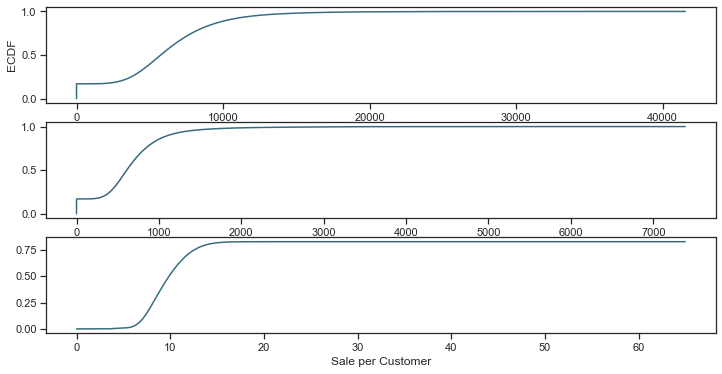

In [5]:
sns.set(style = "ticks")
c = '#386B7F' # grafikler için basit bir renk seçimi
plt.figure(figsize = (12, 6))

plt.subplot(311)
cdf = ECDF(train['Sales'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sales'); plt.ylabel('ECDF');

# ikinci grafik 
plt.subplot(312)
cdf = ECDF(train['Customers'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Customers');


plt.subplot(313)
cdf = ECDF(train['SalePerCustomer'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sale per Customer');

Görüldüğü gibi hemen hemen %20 lik bir kısımda sıfır satış gözükmektedir. Bizim ilgilendiğimiz müşteriler ve bunların hemen hemen %80 lik kısmında günlük satışlar 1000 in altında gözüküyor. Burada aklımıza hiç satış olmayan günlerin bu grafiği etkilemiş olabileceği geliyor... Cevaplamak istediğimiz soru şu şekilde; acaba sıfır satış yapılan günler sadece mağazanın kapalı olması ile mi alakalı?

### Eksik değerler
#### Kapalı mağazalar ve sıfır satış yapan mağazalar

In [6]:
# kapalı mağazalar
train[(train.Open == 0) & (train.Sales == 0)].head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-07-31,292,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-31,876,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-30,292,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-30,876,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-29,292,3,0,0,0,1,0,1,2015,7,29,31,NaN


Verisetinde 172817 tane kapalı mağaza bulunmakta. Bu sayı hemen hemen tüm gözlem değerlerinin %10 una tekabül etmekte. Etki altında kalmış bir tahmin modeli istemediğimizden bu değerleri eliyoruz.

Şimdi ise sıfır satış yapmış mağazalara göz atalım.

In [7]:
# açık fakat sıfır satış yapmış mağazalar
zero_sales = train[(train.Open != 0) & (train.Sales == 0)]
print("Toplam: ", zero_sales.shape)
zero_sales.head(5)

Toplam:  (54, 13)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-05-15,971,5,0,0,1,0,0,1,2015,5,15,20,NaN
2015-03-26,674,4,0,0,1,0,0,0,2015,3,26,13,NaN
2015-02-05,699,4,0,0,1,1,0,0,2015,2,5,6,NaN
2014-10-01,708,3,0,0,1,1,0,0,2014,10,1,40,NaN
2014-09-22,357,1,0,0,1,0,0,0,2014,9,22,39,NaN


İlginçtir ki çalışma günü olmasına rağmen sıfır satış yapmış mağazalar gözlemlemekteyiz. Verisetimizde toplam 54 gün bulunmakta, bu sebeple bazı olağandışı faktörlerin(mesela grev) etkileşimde olduklarını söyleyebiliriz.


In [8]:
print("Modelimizde kullanılmayacak, satış yapamamış kapalı mağazalar ve tatil nedeni ile kapalı mağazalar.")
train = train[(train["Open"] != 0) & (train['Sales'] != 0)]

print("Toplam: ", train.shape)

Modelimizde kullanılmayacak, satış yapamamış kapalı mağazalar ve tatil nedeni ile kapalı mağazalar.
Toplam:  (844338, 13)


Mağazalar verisetimize bir göz atalım.

In [9]:

store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


- Store: her mağaza için birer Id
- StoreType: 4 farklı mağaza grubundan hangi gruba ait olduğunu belirten değişkenimiz
- Assortment: ürün çeşitliliği seviyesini gösteren değişken. a:basit b:orta c:fena
- CompetitionDistance: en yakın rakip mağazaya metre cinsinden uzaklığı
- CompetitionOpenSince[Month/Year]:rakip mağazanın ay ve yıl bazında açılış tarihi
- Promo2: devam eden prosmosyonların ilgili mağazada uygulanıp uygulanmadığı. 0 = uygulanıyor 1 = uygulanıyor
- Promo2Since[Year/Week]: mağazanın promosyona başlangıç tarihini yıl ve hafta bazında gösteren değişken
- PromoInterval: promosyonun ardışık yıllar bazında yürürlülükte olduğu ayları gösterir. mesela "Feb,May,Aug,Nov" ; her yıl bu aylarda bu promosyon yürürlülükte kaldı , gibi düşünülebilir.


In [10]:
# eksik değerler için sorgu
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

Görüldüğü gibi ilgilenmemiz gereken bazı eksik değerler mevcut, `CompetitionDistance` ile başlayalım.

In [11]:
#CompetitionDistance değişkenindeki eksik değerler
store[pd.isnull(store.CompetitionDistance)]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


İlgili veriler basitçe verisetimizde bulunmamaktadır. Eksik veriler ile ilgili bir desen(pattern) gözlemlenmemektedir. Bu bağlamda,ortalamadan neredeyse iki kat az olan medyan değerlerini NaN ile doldurmak mantıklı olacaktır.

In [12]:
# medyan değerlerini NaN ile doldurma (çarpıklık dağılımı)
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)

Bir diğer eksik değerleri olan `Promo2SinceWeek` değişkenine bakalım.

In [13]:
# no promo = no information about the promo?
_ = store[pd.isnull(store.Promo2SinceWeek)]
_[_.Promo2 != 0].shape

(0, 10)

Bu değişkenden bilgi elde edemediğimiz için değerlerini sıfır ile değiştirebiliriz. Aynı dinamikler `CompetitionOpenSinceMonth` ve `CompetitionOpenSinceYear`değişkenleri içinde geçerli olacaktır. 

In [14]:
# Na değerlerini sıfır ile değiştirmek
store.fillna(0, inplace = True)

In [15]:
# inner join argümanı ile hem train hem de store setinde 
# gözlemlenen ortak değerleri birleştirelim
train_store = pd.merge(train, store, how = 'inner', on = 'Store')

print("In total: ", train_store.shape)
train_store.head()

In total:  (844338, 22)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,7,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015,7,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015,7,...,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015,7,...,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


### Mağaza Tipleri

Bu kısımda `StoreType` değişkenini daha detaylı inceleyip, ana metriğimiz olan `Sales` hedef değişkeninin kendisine olan dağılımına bakacağız.  

In [16]:
train_store.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


`StoreType` değişkeninin B sınıfı en yüksek satış ortalamasına sahip sınıfımız, fakat elimizde bu sınıfla ilgili daha az data var. Bu yüzden `Sales` ve `Customers`değişkenlerinin kendi içlerindeki toplamlarına bakıp hangi mağaza tipinin daha çok satış yaptığını ve hangisinin daha kalabalık olduğunu bulalım.

In [17]:
train_store.groupby('StoreType')['Customers', 'Sales'].sum()

,Customers,Sales
StoreType,,
a,363541431,3165334859
b,31465616,159231395
c,92129705,783221426
d,156904995,1765392943


A>D  sınıfları hem satış hemde müşteri bazında lk sıradalar..

Peki satış periyodları bazında durum nasıl? Bu soruya cevap aramak için Seaborn Kütüphanesinden facet grid fonksiyonları bize kolaylık sağlayacaktır.

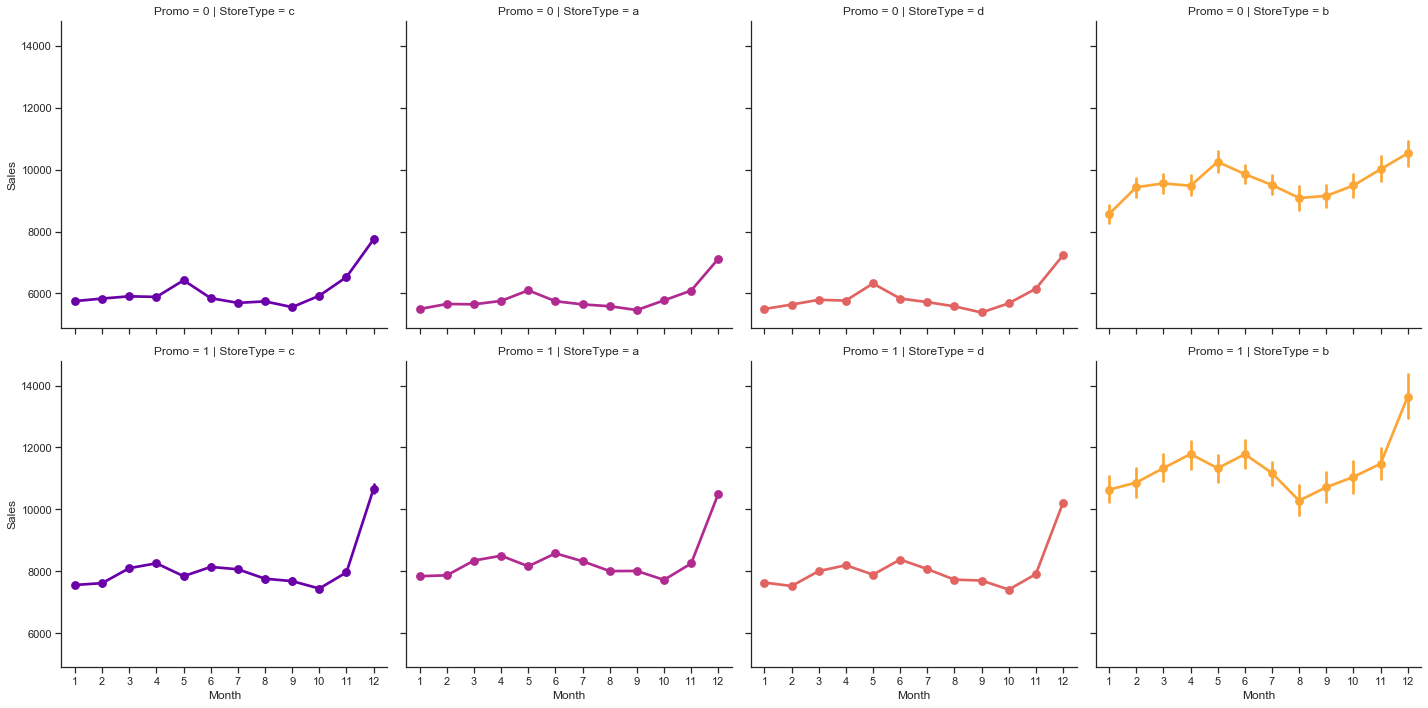

In [18]:
# satış trendleri
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'StoreType', # sütun bazında mağaza tipi
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo', # satır bazında mağazalardaki promosyon
               color = c) 

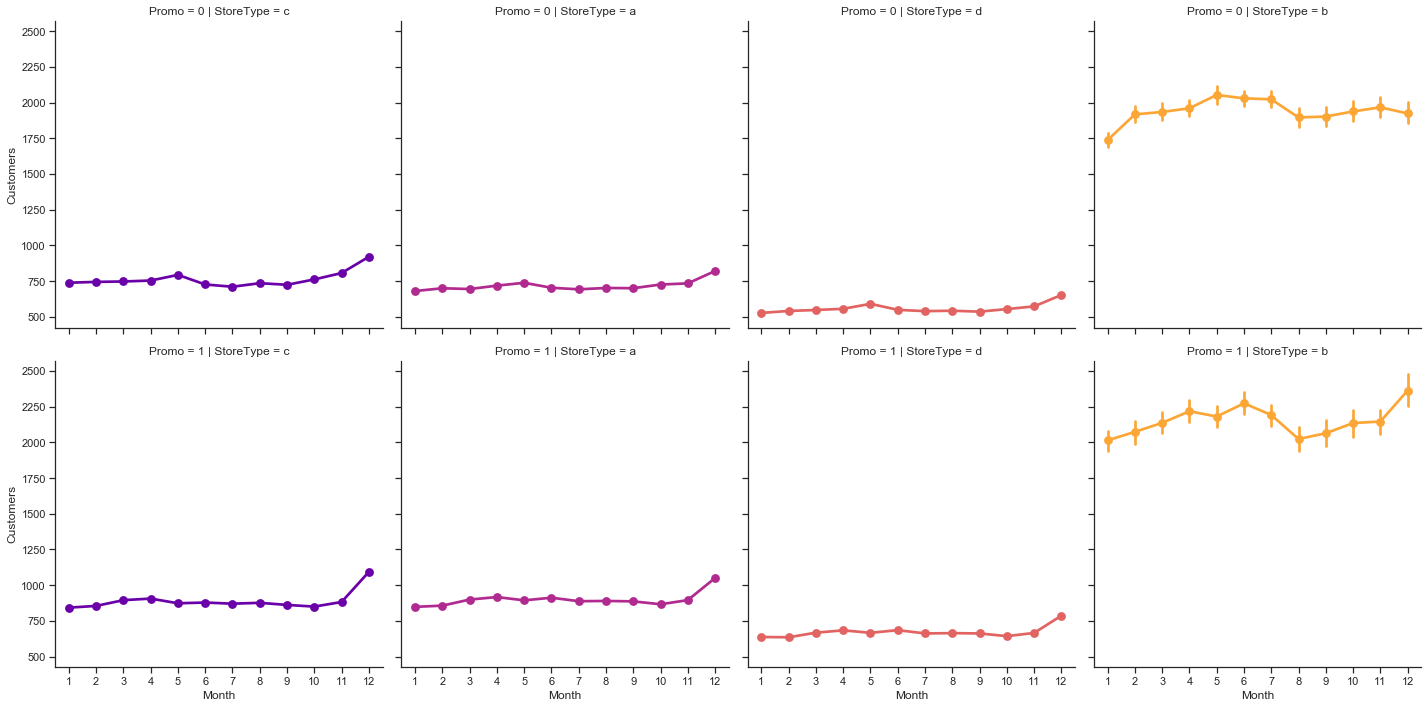

In [19]:
# satış trendleri
sns.factorplot(data = train_store, x = 'Month', y = "Customers", 
               col = 'StoreType', # sütun bazında ağaza tipi
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo', # satır bazında mağazalardaki promosyon
               color = c) 

Tüm mağaza tipleri aynı trend-i farklı skalalarda takip ediyor. Ayrıca noel periyodunda satışların yükseldiğini şimdiden görebiliyoruz. Bu konju ile ilgili zaman serisi analizinde daha detaylı konuşuyor olacağız.

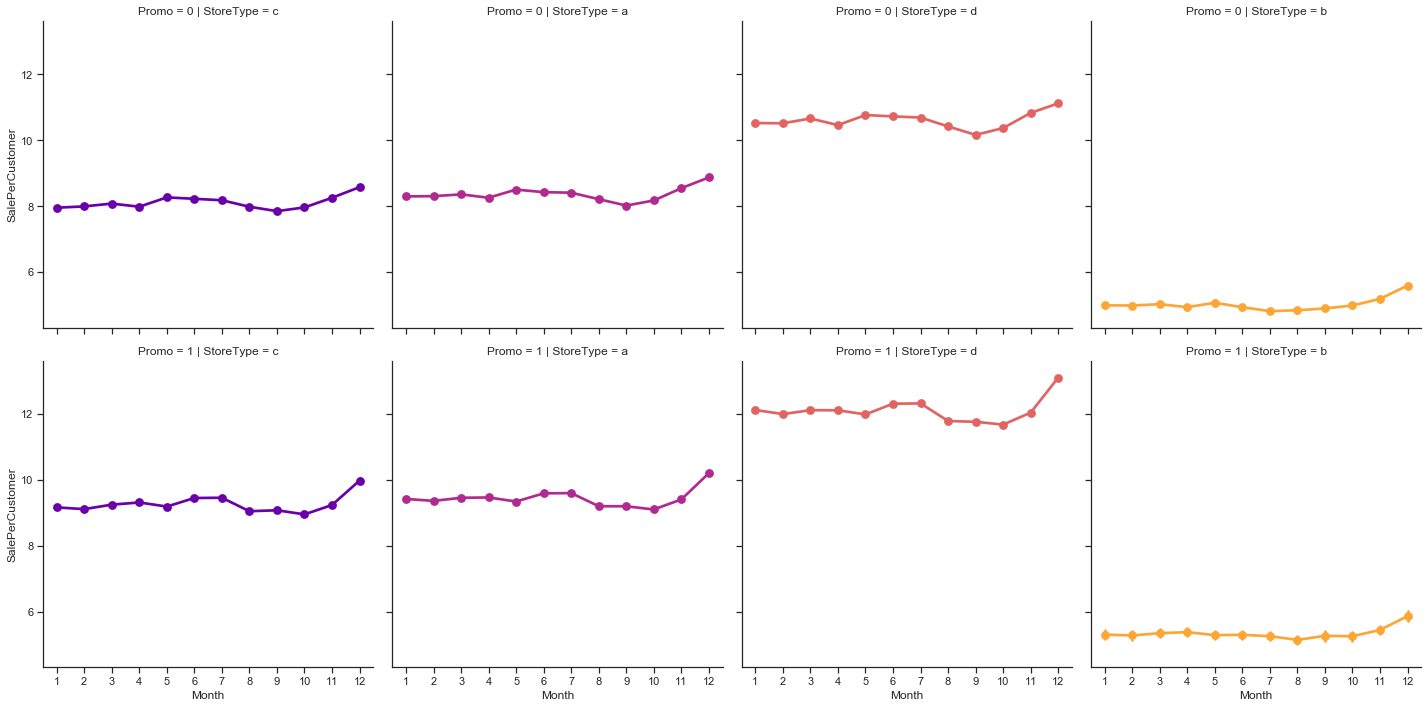

In [20]:
# müşteri trendlerine göre satışlar
sns.factorplot(data = train_store, x = 'Month', y = "SalePerCustomer", 
               col = 'StoreType', # sütun bazında mağaza tipine göre
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo', # satır bazında promosyona göre
               color = c) 

Her ne kadar yukarıda B sınıfı mağazalar daha çok satış yapan mağazalar çıkarımını yaptıysak da, görünen o ki bu doğru bir bilgi değil. Müşteri başına satış grafği inelendiğinde D sınıfının promosypn günlerinde kişibaşı 12, promosyon olmayan günlerde ise 10 Euro civarında satış yaptığını görüyoruz. A ve C sınıfları için ise bu rakam 9 Euro civarında.
En küçük müşteri başına satış oranına sahip olan B sınıfı ise müşteri profili ile ilgili bilgiler vermektedir: çok sayıda müşteri genel olarak küçük ürünler için(ya da ucuz ürünler) alışveriş yapmaktadır.

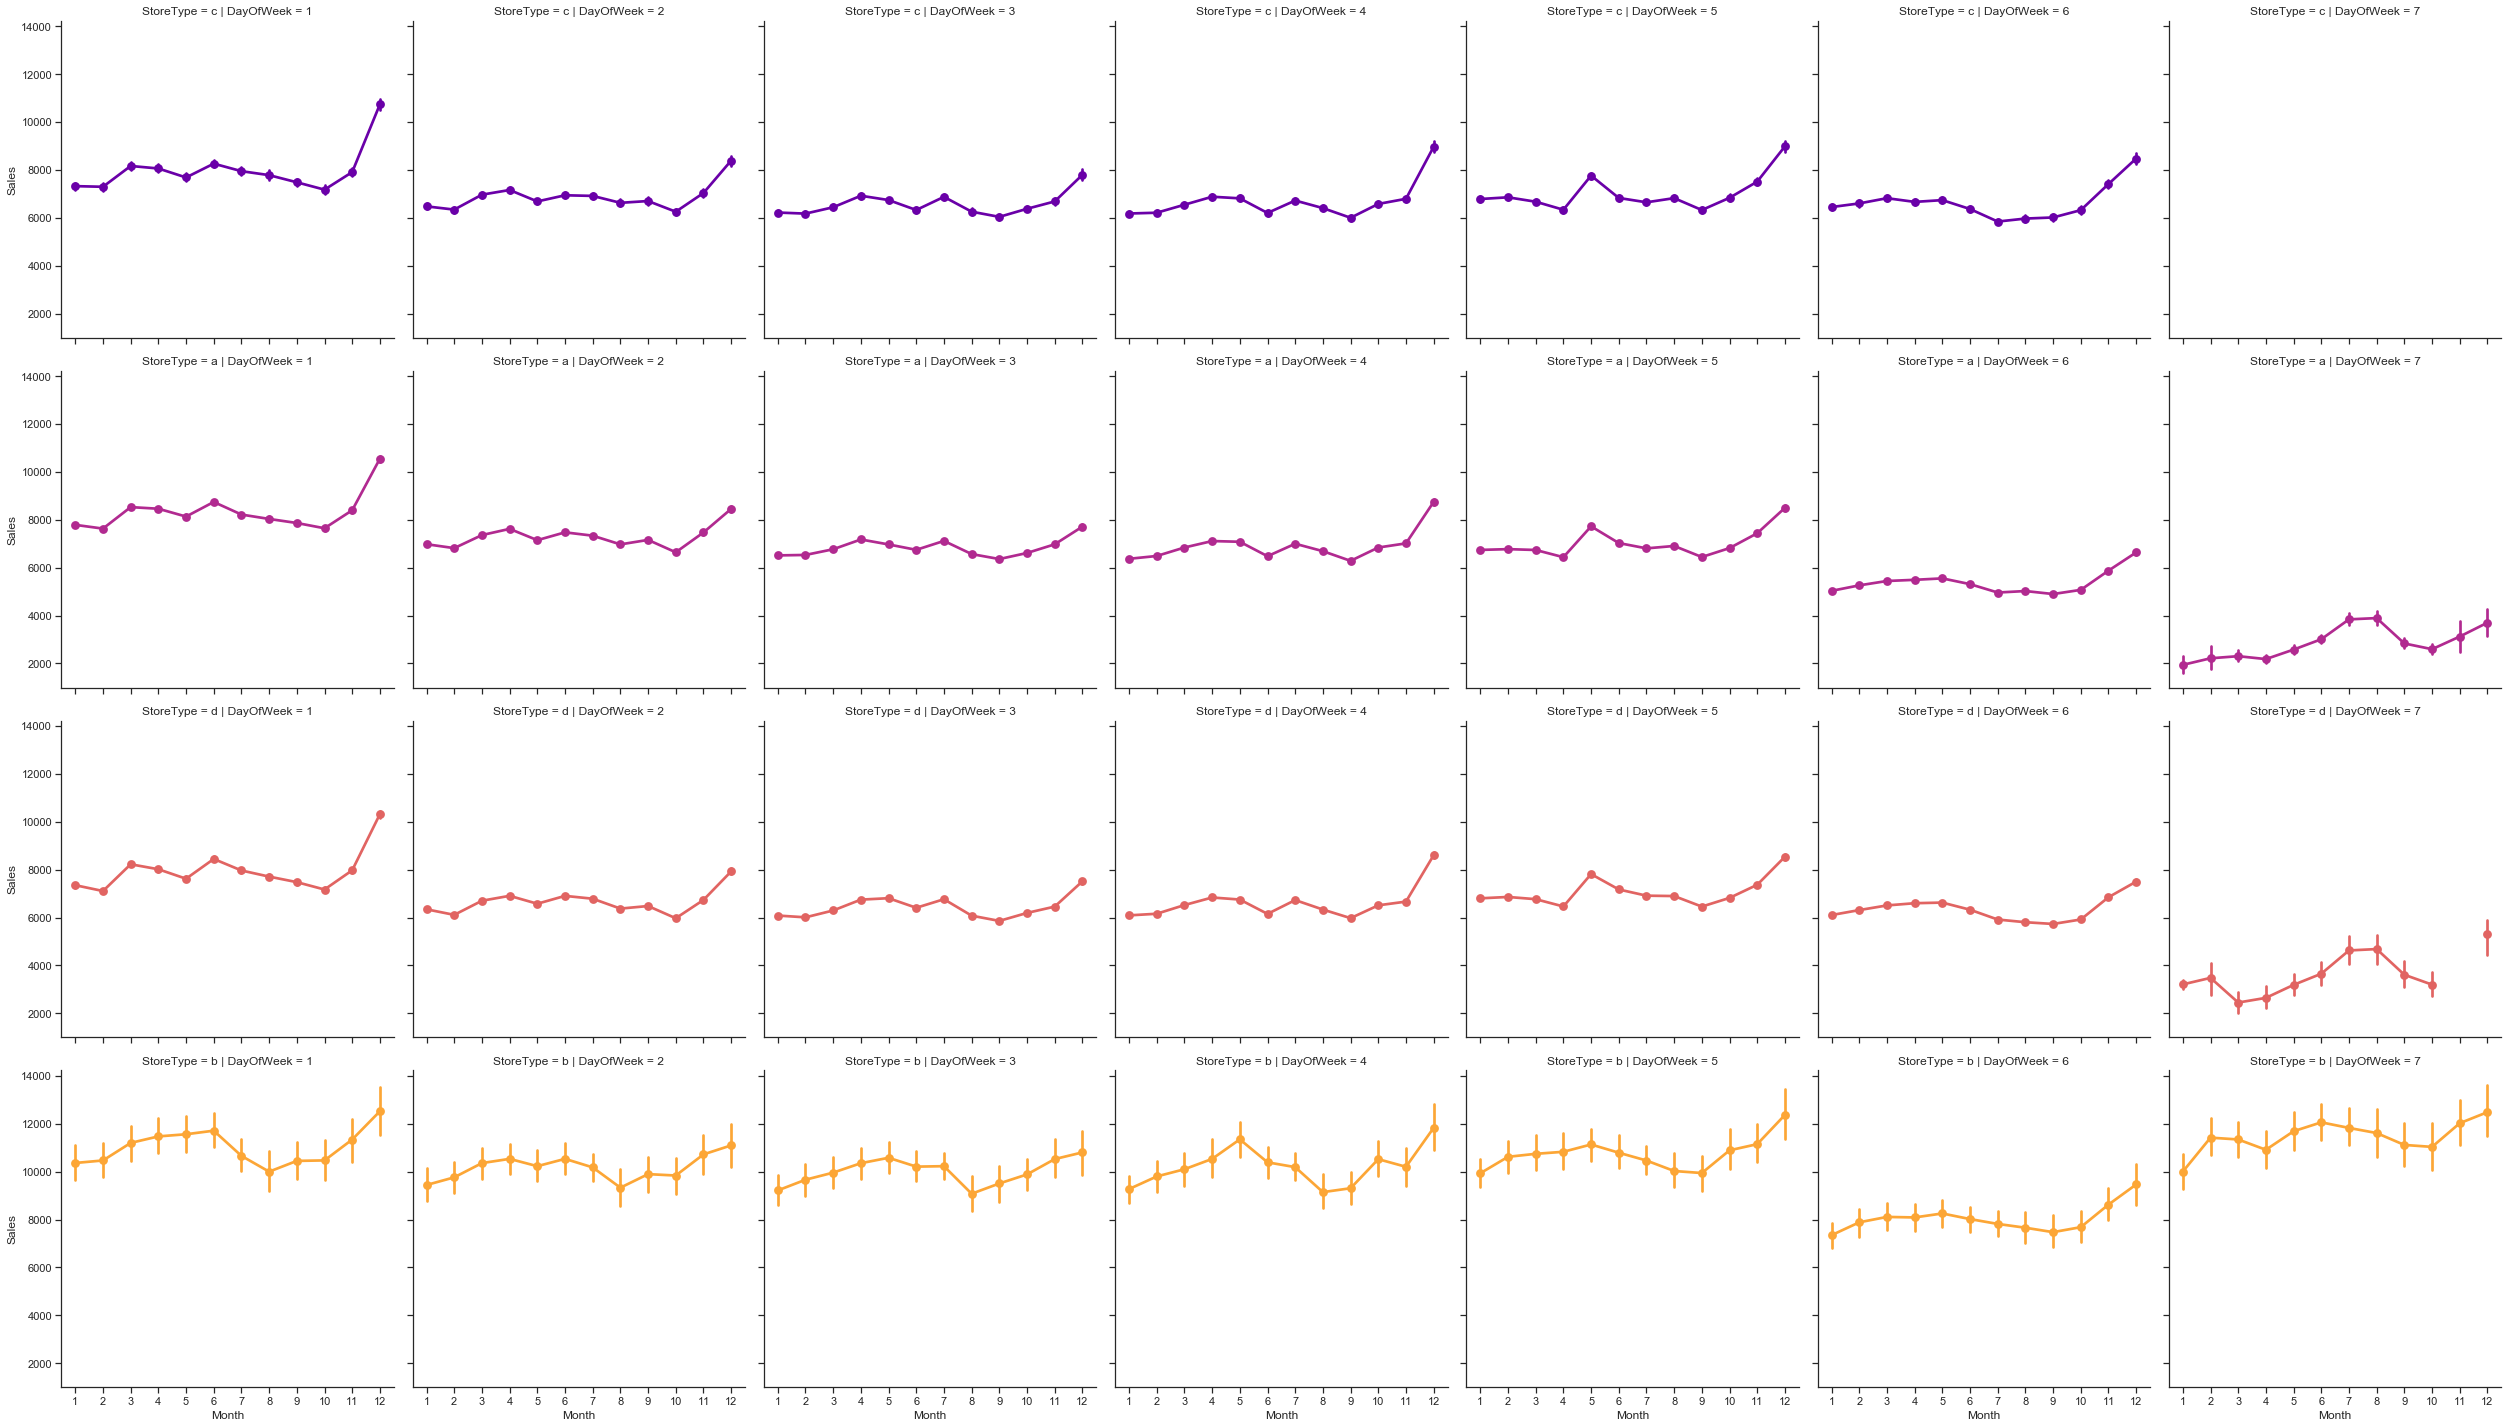

In [21]:
# müşteriler
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'DayOfWeek', 
               palette = 'plasma',
               hue = 'StoreType',
               row = 'StoreType', 
               color = c) 

Görüldüğü gibi C sınıfı mağazalar pazar günleri kapalı, diğer sınıf mağazaların çoğu ise bu günlerde açık. İlginç bir gözlem; D sınıfı mağazalar Ocak ve Şubat aylarında pazar günleri kapalı kalmış... Pazar günleri açık olan mağazalara daha yakından bakalım.

In [22]:
# Pazar açık olan mağazalar
train_store[(train_store.Open == 1) & (train_store.DayOfWeek == 7)]['Store'].unique()

array([  85,  122,  209,  259,  262,  274,  299,  310,  335,  353,  423,
        433,  453,  494,  512,  524,  530,  562,  578,  676,  682,  732,
        733,  769,  863,  867,  877,  931,  948, 1045, 1081, 1097, 1099],
      dtype=int64)

Keşifçi analizimizi sonlandırmak adına, hangi zamanlarda hangi promosyonların aktif olduğunu gösteren bir değişken oluşturalım.

In [23]:
# competition open time (in months)
train_store['CompetitionOpen'] = 12 * (train_store.Year - train_store.CompetitionOpenSinceYear) + \
        (train_store.Month - train_store.CompetitionOpenSinceMonth)
    
# Promo open time
train_store['PromoOpen'] = 12 * (train_store.Year - train_store.Promo2SinceYear) + \
        (train_store.WeekOfYear - train_store.Promo2SinceWeek) / 4.0

# replace NA's by 0
train_store.fillna(0, inplace = True)

# average PromoOpen time and CompetitionOpen time per store type
train_store.loc[:, ['StoreType', 'Sales', 'Customers', 'PromoOpen', 'CompetitionOpen']].groupby('StoreType').mean()

,Sales,Customers,PromoOpen,CompetitionOpen
StoreType,,,,
a,6925.697986,795.422370,12918.492198,7115.514452
b,10233.380141,2022.211825,17199.328069,11364.495244
c,6933.126425,815.538073,12158.636107,6745.418694
d,6822.300064,606.353935,10421.916846,9028.526526


En kalabalık mağaza sınıfı A olmasına rağmen bu cins mağazalar çok rekabetçi gözükmüyor. B sınıfı ise promosyon günlerini en uzun süre gerçekleştiren sınıf olarak gözüküyor.

### Korelasyon Analizi

Heatmap ile korelasyon gözlemi gerçekleştirelim

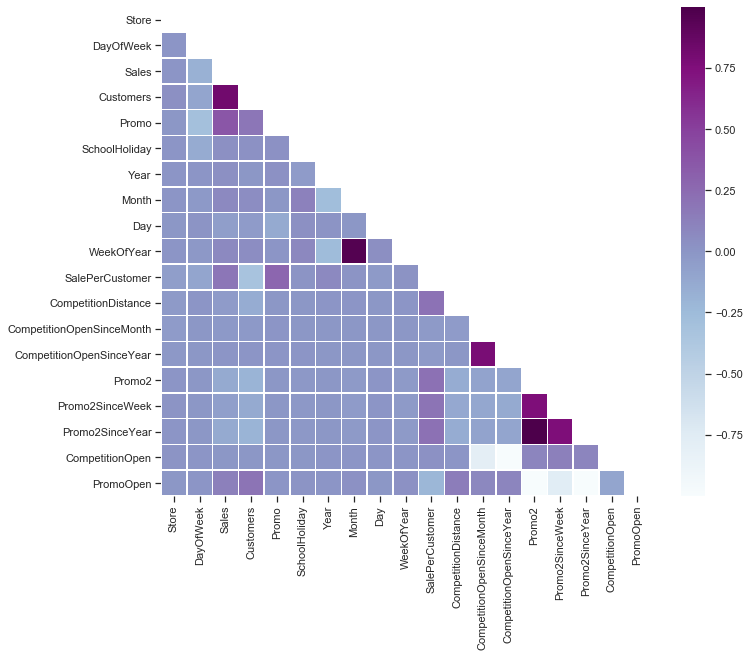

In [24]:
# Korelasyon hesaplanması
corr_all = train_store.drop('Open', axis = 1).corr()

mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize = (11, 9))

sns.heatmap(corr_all, mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show()

Daha önce de gözlemlediğimiz gibi Satışlar e mağazadaki müşteri sayısı arasında pozitif güçlü bir korelasyon mevcut. Aynı zamanda promosyon günleri ve müşteri sayısı arasında da pozitif korelasyon gözlemliyoruz.

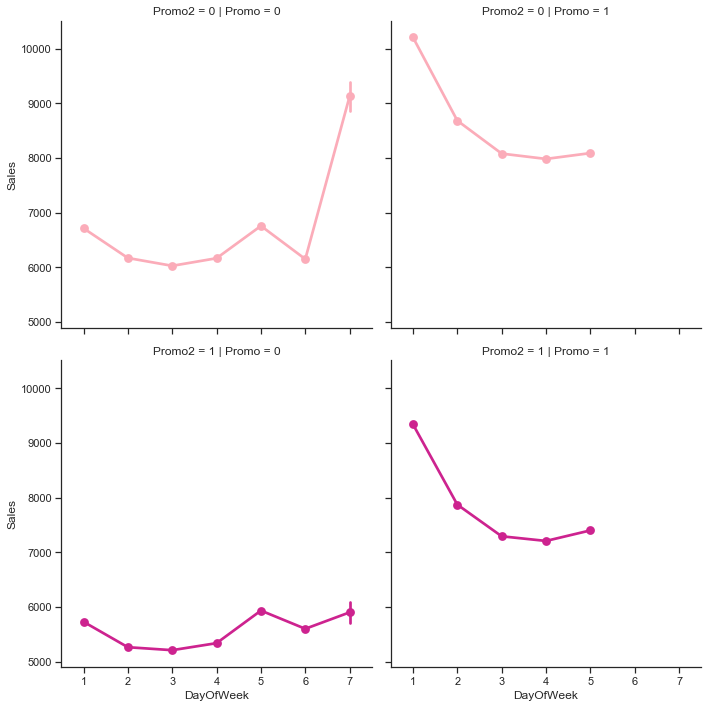

In [25]:
# Müşteri trendlerine göre satış
sns.factorplot(data = train_store, x = 'DayOfWeek', y = "Sales", 
               col = 'Promo', 
               row = 'Promo2',
               hue = 'Promo2',
               palette = 'RdPu') 

##### Bazı yorumlar:
- Promosyon olmadığı durumlarda satışlar pazar günleri peak yapıyor. Buradan C sınıfının pazar günleri açık olmadığı sonucuna varabiliriz.
- Promosyon gerçekleştiren diğer mağazalar ise en yüksek satışlarını pazartesi gerçekleştiriyor. Bu bize ilgili firmanın satış stratejileri ile ilgili bilgi sağlamaktadır.

### Keşifçi Veri Analizi Sonuçları

-  A sınıfı mağazalar en kalabalık  en çok satış gerçekleştren mağazalar.


- D sınıfı en zengin müşterilere sahip, buradan ilgili firmanın bu sınıf mağazalarda daha geniş bir skalada ürün satması faydalı ve karlı olabilir.


-  D sınıfı mağazalar ise en çok satış rakamı ve müşteri sayısına sahip olmasına rağmen müşteriler daha ucuz ve az sayıda ürüne yönelmekte. dolayısı ile bu mağazalar satış arttırma bazında yüksek potansiyele sahip.


-  Müşteriler promosyon olmadığında bile pazartesi daha çok ürün alma eğilimi göstermiş.


- 2. promosyon bilgisini gösteren Promo2 değişkeni hedef değişkenimiz ile hiçbir korelatif bağ göstermemektedir.

<br>
##  Mağaza Tipi için Zaman Serisi Analizi

 Neden klasik regresyon yerine zaman serileri tercih edildi?

- Zaman kısaca bağımlıdır. Lineer regresyon ise bağımsız olduğu için bu notebook ta tercih edilmemiştir. 
- Yükselen ve inen trendlerin yanında zaman serilerinde tatil gibi etkenleri daha detaylı bir şekilde inceleyebilmekteyiz.

Zaman serisi analizimizi tek tek mağazalar yerine mağaza sınıfları bazında yapacağız. Bunun nedeni farklı trend ve tatil günlerinin hedef değişkenimiz üzerine olan etkilerini daha kolay bir şekilde gözlemleyecek olmamız.

#####  Her sınıftan, sınıfları temsil etmesi için birer mağaza alalım:
-  A sınıfından 2 numaralı mağaza,
-  B den 85 numara,
-  C den 1,
-  D sınıfından ise 13 numaralı mağaza.

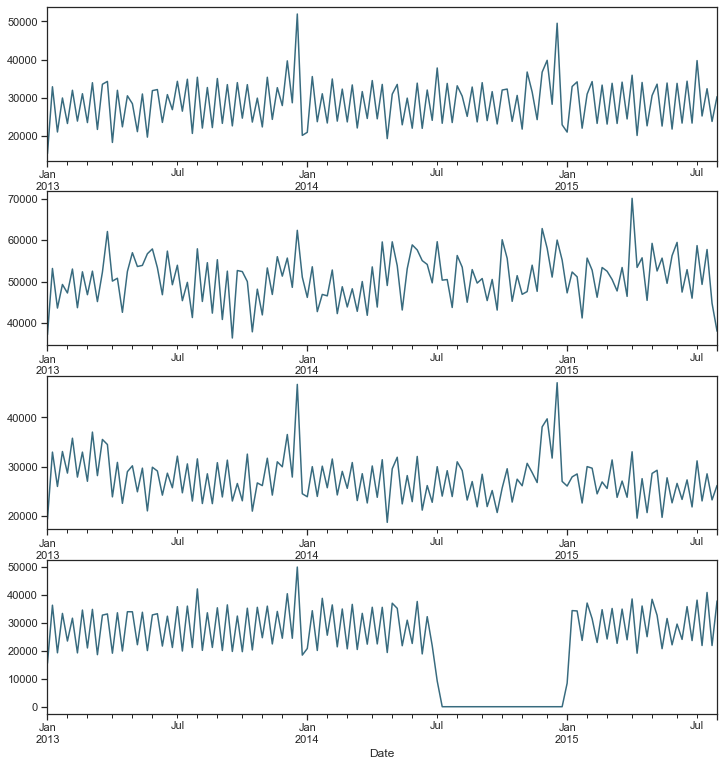

In [26]:
# inputlarımız float cinsinden olmalı
train['Sales'] = train['Sales'] * 1.0

# store types
sales_a = train[train.Store == 2]['Sales']
sales_b = train[train.Store == 85]['Sales'].sort_index(ascending = True) # solve the reverse order
sales_c = train[train.Store == 1]['Sales']
sales_d = train[train.Store == 13]['Sales']

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# mağaza tipleri
sales_a.resample('W').sum().plot(color = c, ax = ax1)
sales_b.resample('W').sum().plot(color = c, ax = ax2)
sales_c.resample('W').sum().plot(color = c, ax = ax3)
sales_d.resample('W').sum().plot(color = c, ax = ax4)

A ve C sınıfları için toptan satışlar noel sezonunda optimum seviyede gözlemleniyor ve tatillerden sonra satışlarda sürekli bir düşme oluyor. Aynı gözlemi D sınıfı içinde yapabiliriz fakat görüldüğü gibi bazı eksik bilgiler mevcut, buradan ilgili tarihlerde bu mağazaların kapalı olduğu sonuu çıkabilir.

### Yıllık Trend

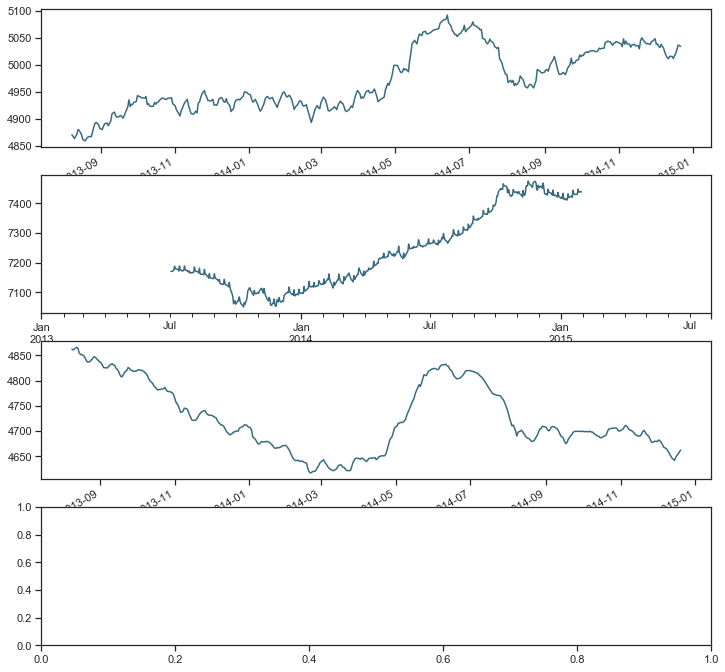

In [27]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# aylık
decomposition_a = seasonal_decompose(sales_a, model = 'additive', freq = 365)
decomposition_a.trend.plot(color = c, ax = ax1)

decomposition_b = seasonal_decompose(sales_b, model = 'additive', freq = 365)
decomposition_b.trend.plot(color = c, ax = ax2)

decomposition_c = seasonal_decompose(sales_c, model = 'additive', freq = 365)
decomposition_c.trend.plot(color = c, ax = ax3)


### Otokorelasyon Analizi

Şimdiki adımda otokorelasyon ve kısmi otokorelasyon analizlerimizi gerçekleştireceğiz.

ACF--> Otokorelasyon fonksiyonu serinin bazı değerleri ve gecikmeli değerleri arasındaki ilişkinin (correlation) boyutunu belirler. 

PACF--> Kısmi otokorelasyon katsayısı ise diğer gecikmeli serilerin (örneğin zt1, zt-2,…, zt-k+1) etkileri ihmal edildiğinde zt
ile zt+k serileri arasındaki ilişki miktarını verir. 

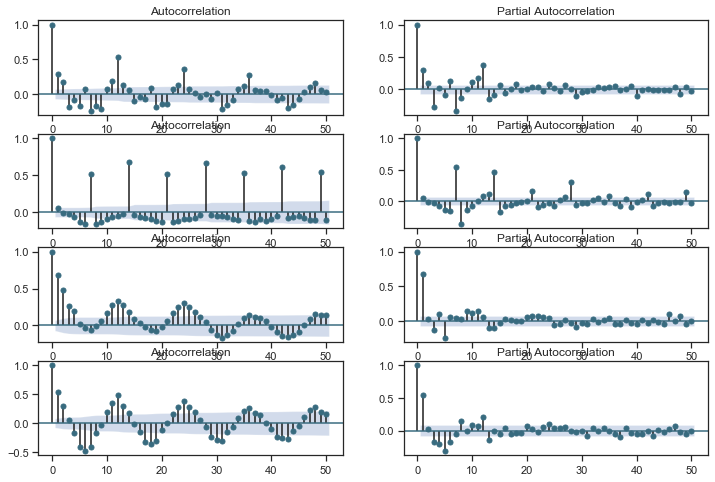

In [28]:

plt.figure(figsize = (12, 8))

# acf and pacf for A
plt.subplot(421); plot_acf(sales_a, lags = 50, ax = plt.gca(), color = c)
plt.subplot(422); plot_pacf(sales_a, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for B
plt.subplot(423); plot_acf(sales_b, lags = 50, ax = plt.gca(), color = c)
plt.subplot(424); plot_pacf(sales_b, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for C
plt.subplot(425); plot_acf(sales_c, lags = 50, ax = plt.gca(), color = c)
plt.subplot(426); plot_pacf(sales_c, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for D
plt.subplot(427); plot_acf(sales_d, lags = 50, ax = plt.gca(), color = c)
plt.subplot(428); plot_pacf(sales_d, lags = 50, ax = plt.gca(), color = c)

plt.show()

A ve B sınıflarında durağanlık gözükürken C ve D sınıfları için durağanlıktan bahsetmek zor olacaktır.

## Zaman Serisi Analizi ve Prophet Kütüphanesi ile Tahmin Modeli
####  6 haftalık tahmin modeli

In [29]:
# data import
df = pd.read_csv("train.csv",  
                    low_memory = False)

# kapalı ve satış olmayan mağazaların kaldırılması
df = df[(df["Open"] != 0) & (df['Sales'] != 0)]

#  C sınıfı için satış
sales = df[df.Store == 1].loc[:, ['Date', 'Sales']]

# 2013 den 2015 e doğru sıralama
sales = sales.sort_index(ascending = False)


sales['Date'] = pd.DatetimeIndex(sales['Date'])
sales.dtypes

Date     datetime64[ns]
Sales             int64
dtype: object

In [30]:

sales = sales.rename(columns = {'Date': 'ds',
                                'Sales': 'y'})
sales.head()

,ds,y
1014980,2013-01-02,5530
1013865,2013-01-03,4327
1012750,2013-01-04,4486
1011635,2013-01-05,4997
1009405,2013-01-07,7176


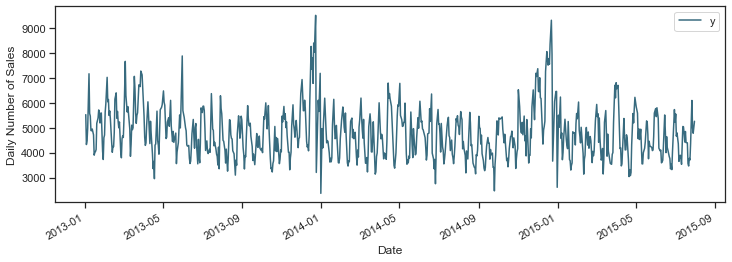

In [31]:

ax = sales.set_index('ds').plot(figsize = (12, 4), color = c)
ax.set_ylabel('Daily Number of Sales')
ax.set_xlabel('Date')
plt.show()

### Tatillerin Modellenmesi

Prophet kütüphanesi bize aynı zamanda tatil günlerinide modelleme imkanı sağlar.

In [32]:

state_dates = df[(df.StateHoliday == 'a') | (df.StateHoliday == 'b') & (df.StateHoliday == 'c')].loc[:, 'Date'].values
school_dates = df[df.SchoolHoliday == 1].loc[:, 'Date'].values

state = pd.DataFrame({'holiday': 'state_holiday',
                      'ds': pd.to_datetime(state_dates)})
school = pd.DataFrame({'holiday': 'school_holiday',
                      'ds': pd.to_datetime(school_dates)})

holidays = pd.concat((state, school))      
holidays.head()

,holiday,ds
0,state_holiday,2015-06-04
1,state_holiday,2015-06-04
2,state_holiday,2015-06-04
3,state_holiday,2015-06-04
4,state_holiday,2015-06-04


In [33]:

my_model = Prophet(interval_width = 0.95, 
                   holidays = holidays)
my_model.fit(sales)


future_dates = my_model.make_future_dataframe(periods = 6*7)

print("First week to forecast.")
future_dates.tail(7)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


First week to forecast.


,ds
816,2015-09-05
817,2015-09-06
818,2015-09-07
819,2015-09-08
820,2015-09-09
821,2015-09-10
822,2015-09-11


In [34]:
# tahminler
forecast = my_model.predict(future_dates)


forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
816,2015-09-05,4107.928508,2400.409315,5749.689282
817,2015-09-06,4081.629384,2509.312071,5664.051658
818,2015-09-07,4177.429012,2656.573726,5795.883707
819,2015-09-08,3680.085778,2168.492779,5196.117265
820,2015-09-09,3566.493508,1916.467096,5258.014924
821,2015-09-10,3478.576447,1964.368352,5047.070955
822,2015-09-11,3733.596403,2229.746830,5276.976926


In [35]:
fc = forecast[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})

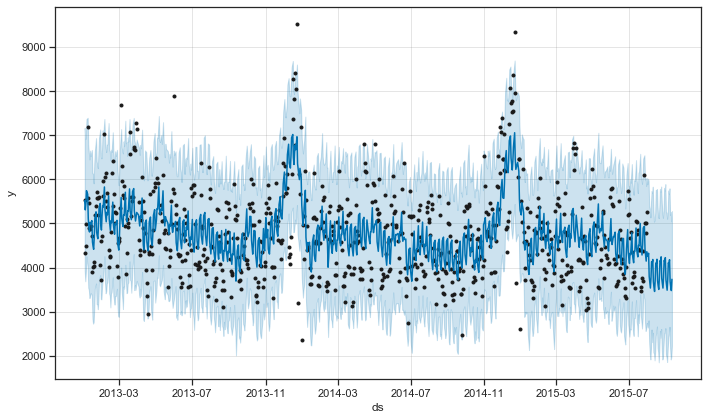

In [36]:
# tahminleri görselleştirme
my_model.plot(forecast);

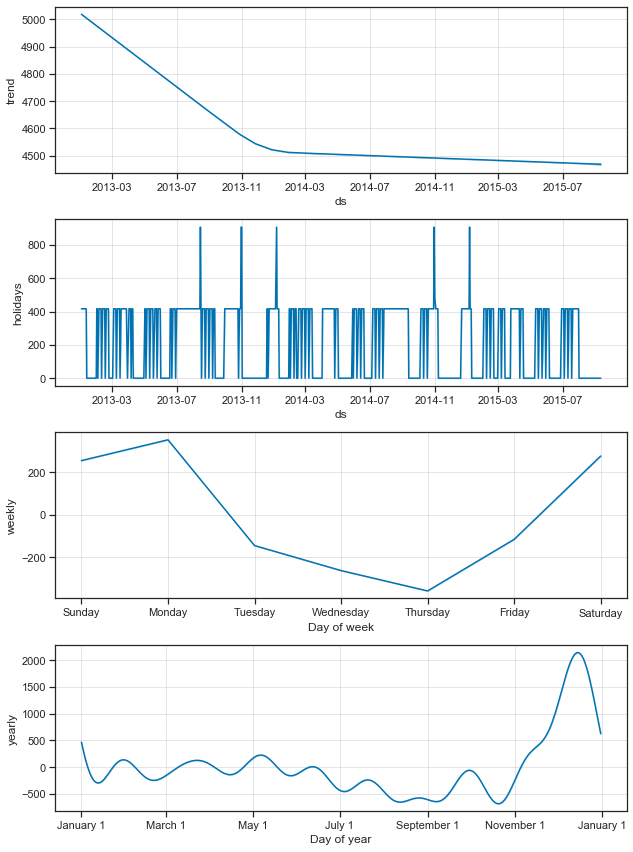

In [37]:
my_model.plot_components(forecast);

İlk grafik 1 numaralı mağazanın aylık satışlarının zamanla arttığını gösterirken ikinci grafik tatil boşluklarının modele entegrasyonunu göstermektedir. 3.grafik pazartesi günü satışların peak yapacağının altını çizmektedir. Son grafik ise en yoğun sezonun noel dönemi olacağını göstermektedir.